In [77]:
import numpy as np
import galsim
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random as rnd

d_lsst = 8.4
ref_lam = 700
Z_N_max = 15   ## highest Zernike order to fit (starting at 2)

## Random Aberrations

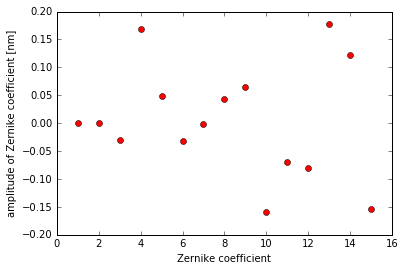

In [67]:
#amplitudes = [(rnd.random()-0.5)*3*(i**(-1/2)) for i in range(2,Z_N_max)]  ## 0.5*wavelength
amplitudes = [(rnd.random()-0.5)*.4 for i in range(2,Z_N_max)]
amplitudes.insert(0,0), amplitudes.insert(0,0)   ## insert 0 for first entry (unused) and piston

pts = np.linspace(1,Z_N_max,Z_N_max)
plt.plot(pts,amplitudes,'ro')
plt.ylabel('amplitude of Zernike coefficient [nm]')
plt.xlabel('Zernike coefficient')
plt.show()

0.93263538411


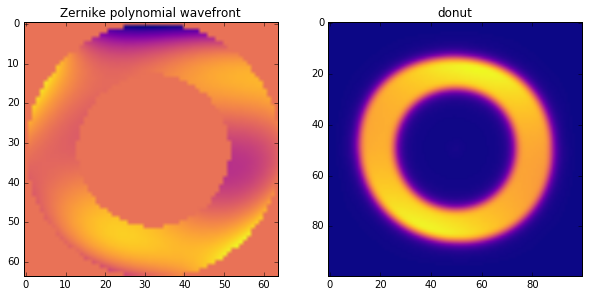

In [72]:
z_poly = galsim.OpticalScreen(diam=d_lsst, aberrations=amplitudes,lam_0=ref_lam)
aperture = galsim.Aperture(diam=d_lsst, lam=ref_lam, obscuration=.6, screen_list=z_poly,
                           oversampling=.5,pad_factor=.25)
wf = z_poly.wavefront(aperture.u,aperture.v)*aperture.illuminated
wf = wf/ref_lam ## now in waves!
print wf.max()

defocus_amplitudes = [a for a in amplitudes]
defocus_amplitudes[4] = 32  ## set defocus
optics_psf = galsim.OpticalPSF(lam=ref_lam, diam=d_lsst, obscuration=0.61,
                               oversampling=.5, pad_factor=4.0,
                               aberrations=defocus_amplitudes)
kolmogorov = galsim.Kolmogorov(lam=ref_lam, r0 = .2)
psf = galsim.Convolve(optics_psf,kolmogorov).drawImage(nx=100,ny=100, scale=0.2).array
psf = psf/psf.max() #normalize pixels


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax2.imshow(psf,cmap='plasma')
ax2.set_title('donut')
ax1.imshow(wf,cmap='plasma')
ax1.set_title('Zernike polynomial wavefront')
plt.show()

## Load data

In [75]:
data = pd.read_pickle('/Users/clairealice/Documents/Research/Burchat/DonutNN/simulatedData.p')

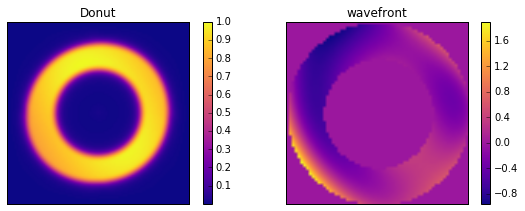

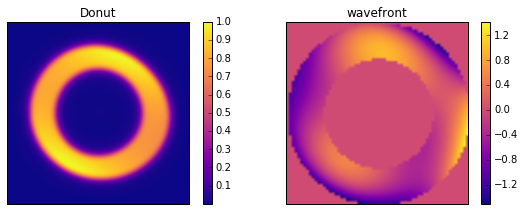

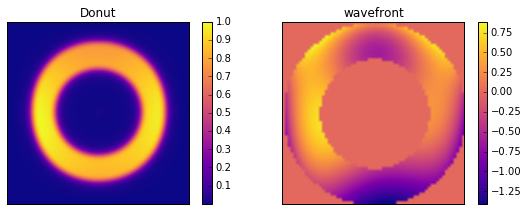

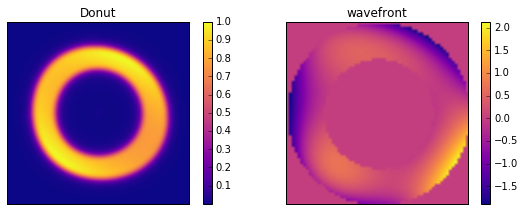

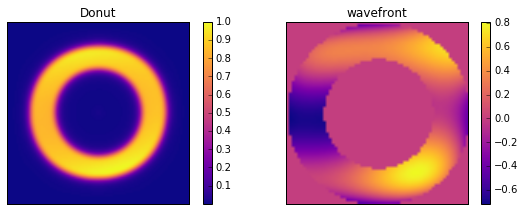

In [79]:
for i in data.sample(5,axis=0).index.values:
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(1,2,1)
    ax.set_title("Donut")
    imdonut = ax.imshow(data['psf'][i],cmap='plasma')
    fig.colorbar(imdonut)
    ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
    
    ax = fig.add_subplot(1,2,2)
    ax.set_title("wavefront")
    imwf = ax.imshow(data['wavefront'][i],cmap='plasma')
    fig.colorbar(imwf)
    ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
    
    plt.tight_layout()
    plt.show()

## Split into test and train

In [80]:
Ntest = 10
data = data.iloc[np.random.permutation(len(data))]
traindata = data.iloc[:len(data)-Ntest]
traindata.reset_index(drop=True,inplace=True)
testdata = data.iloc[len(data)-Ntest:]
testdata.reset_index(drop=True,inplace=True)

## Baseline: nearest neighbor

In [90]:
## pass through all the test samples and compute lowest entropy training example
from scipy.stats import entropy

KLNN = []
for testPsf in testdata['psf'].values:
    distList = []
    for i in traindata.index.values:
        psfP = [.01 if j < .01 else j for j in testPsf.flatten()]
        testP = [.01 if j < .01 else j for j in traindata['psf'][i].flatten()]
        dist = entropy(testP,psfP)
        distList.append( (dist,i) )
    KLNN.append(min(distList)) 

SPNN = []
for testPsf in testdata['psf'].values:
    distList = []
    for i in traindata.index.values:
        dist = np.sum(np.square(testPsf-traindata['psf'][i]))
        distList.append( (dist,i) )
    SPNN.append(min(distList)) 

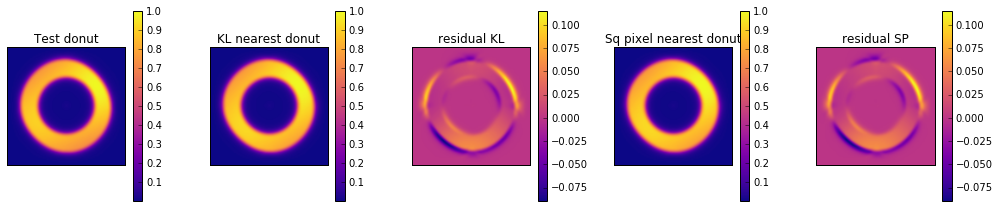

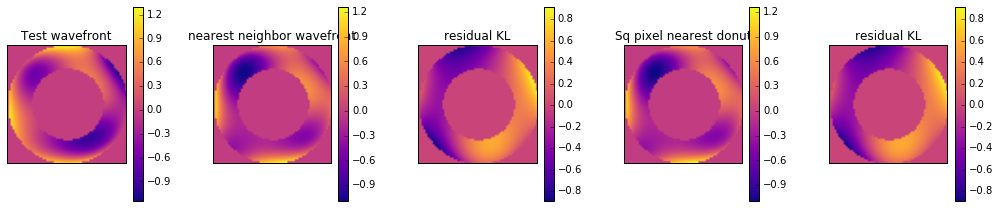

In [106]:
N=9

psf = testdata['psf'][N]
closestKLpsf = traindata['psf'][KLNN[N][1]]
closestSPpsf = traindata['psf'][SPNN[N][1]]
wf = testdata['wavefront'][N]
closestKLwf = traindata['wavefront'][KLNN[N][1]]
closestSPwf = traindata['wavefront'][SPNN[N][1]]

fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(1,5,1)
ax.set_title("Test donut")
imdonut = ax.imshow(psf,cmap='plasma')
fig.colorbar(imdonut)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
ax = fig.add_subplot(1,5,2)
ax.set_title("KL nearest donut")
imkldonut = ax.imshow(closestKLpsf,cmap='plasma')
fig.colorbar(imkldonut)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
ax = fig.add_subplot(1,5,3)
ax.set_title("residual KL")
imresdonut = ax.imshow(closestKLpsf - psf,cmap='plasma')
fig.colorbar(imresdonut)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
ax = fig.add_subplot(1,5,4)
ax.set_title("Sq pixel nearest donut")
imspdonut = ax.imshow(closestSPpsf,cmap='plasma')
fig.colorbar(imspdonut)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
ax = fig.add_subplot(1,5,5)
ax.set_title("residual SP")
imresdonut = ax.imshow(closestSPpsf - psf,cmap='plasma')
fig.colorbar(imresdonut)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
plt.tight_layout()
plt.savefig('donutfig2.png')
plt.show()

fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(1,5,1)
ax.set_title("Test wavefront")
imwf = ax.imshow(wf,cmap='plasma')
fig.colorbar(imwf)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
ax = fig.add_subplot(1,5,2)
ax.set_title("nearest neighbor wavefront")
imcwf = ax.imshow(closestKLwf,cmap='plasma')
fig.colorbar(imcwf)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
ax = fig.add_subplot(1,5,3)
ax.set_title("residual KL")
imreswf = ax.imshow(closestKLwf-wf,cmap='plasma')
fig.colorbar(imreswf)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
ax = fig.add_subplot(1,5,4)
ax.set_title("Sq pixel nearest donut")
imspwf = ax.imshow(closestSPwf,cmap='plasma')
fig.colorbar(imspwf)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
ax = fig.add_subplot(1,5,5)
ax.set_title("residual KL")
imreswf = ax.imshow(closestSPwf-wf,cmap='plasma')
fig.colorbar(imreswf)
ax.tick_params(axis='both',labelbottom='off',labelleft='off',bottom='off',right='off',top='off',left='off')
plt.tight_layout()
plt.savefig('wffig2.png')
plt.show()